In [1]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [2]:
from pathlib import Path

import pandas as pd
import seaborn as sns

from transformers import TrainerState

from src.models import get_best_checkpoint

In [3]:
all_model_dirs = list(Path("outputs/models").glob("*/*/*/*"))
checkpoints = []
for d in all_model_dirs:
    if d.stem.startswith("."):
        continue
    try:
        checkpoints.append(d / Path(get_best_checkpoint(d)).name)
    except ValueError:
        continue

In [4]:
trainer_states = [TrainerState.load_from_json(c / "trainer_state.json") for c in checkpoints]

In [5]:
log_df = pd.concat([pd.DataFrame(trainer_state.log_history) for trainer_state in trainer_states],
                   keys=["/".join(str(x.name) for x in c.parents[:4][::-1]) for c in checkpoints], names=["checkpoint"])
log_df

epoch  learning_rate    loss    step  \
checkpoint                                                                  
timit/w2v2_6/rnn_8/phoneme      0     0.00       0.001000  5.0321     1.0   
                                1     0.00       0.001000  1.7893    10.0   
                                2     0.00       0.001000 -0.5806    20.0   
                                3     0.00       0.001000 -0.6159    30.0   
                                4     0.00       0.001000 -0.5067    40.0   
...                                    ...            ...     ...     ...   
timit/w2v2_6/rnn_8-tau1/phoneme 216   0.01       0.000995 -0.8445  1970.0   
                                217   0.01       0.000995 -0.8140  1980.0   
                                218   0.01       0.000995 -0.8394  1990.0   
                                219   0.01       0.000995 -0.8075  2000.0   
                                220   0.01            NaN     NaN  2000.0   

                                     eval_embedding_alignment  \
checkpoint                                                      
timit/w2v2_6/rnn_8/phoneme      0                         NaN   
                                1                         NaN   
                                2                         NaN   
                                3                         NaN   
                                4                         NaN   
...                                                       ...   
timit/w2v2_6/rnn_8-tau1/phoneme 216                       NaN   
                                217                       NaN   
                                218                       NaN   
                                219                       NaN   
                                220                  0.749882   

                                     eval_embedding_alignment_cosine  \
checkpoint                                                             
timit/w2v2_6/rnn_8/phoneme      0                                NaN   
                                1                                NaN   
                                2                                NaN   
                                3                                NaN   
                                4                                NaN   
...                                                              ...   
timit/w2v2_6/rnn_8-tau1/phoneme 216                              NaN   
                                217                              NaN   
                                218                              NaN   
                                219                              NaN   
                                220                         0.180816   

                                     eval_embedding_corr  \
checkpoint                                                 
timit/w2v2_6/rnn_8/phoneme      0                    NaN   
                                1                    NaN   
                                2                    NaN   
                                3                    NaN   
                                4                    NaN   
...                                                  ...   
timit/w2v2_6/rnn_8-tau1/phoneme 216                  NaN   
                                217                  NaN   
                                218                  NaN   
                                219                  NaN   
                                220             0.964179   

                                     eval_embedding_isoscore  \
checkpoint                                                     
timit/w2v2_6/rnn_8/phoneme      0                        NaN   
                                1                        NaN   
                                2                        NaN   
                                3                        NaN   
                                4                        NaN   
...                    

In [6]:
log_df_long = log_df.reset_index().melt(id_vars=["checkpoint", "step"], value_vars=["loss", "eval_loss"])
log_df_long

,checkpoint,step,variable,value
0,timit/w2v2_6/rnn_8/phoneme,1.0,loss,5.03210
1,timit/w2v2_6/rnn_8/phoneme,10.0,loss,1.78930
2,timit/w2v2_6/rnn_8/phoneme,20.0,loss,-0.58060
3,timit/w2v2_6/rnn_8/phoneme,30.0,loss,-0.61590
4,timit/w2v2_6/rnn_8/phoneme,40.0,loss,-0.50670
...,...,...,...,...
8731,timit/w2v2_6/rnn_8-tau1/phoneme,1970.0,eval_loss,NaN
8732,timit/w2v2_6/rnn_8-tau1/phoneme,1980.0,eval_loss,NaN
8733,timit/w2v2_6/rnn_8-tau1/phoneme,1990.0,eval_loss,NaN
8734,timit/w2v2_6/rnn_8-tau1/phoneme,2000.0,eval_loss,NaN


In [7]:
log_df_long[log_df_long.variable == "eval_loss"].groupby("checkpoint").value.min().sort_values()

checkpoint
timit/w2v2_6/rnn_8/biphone_recon                            -9.363153
timit/w2v2_6/rnn_8/word                                     -9.009235
timit/w2v2_6/rnn_8-regularization_cov100/phoneme            -8.528851
timit/w2v2_6/rnn_8-weightdecay0.01/word_10frames            -8.507614
timit/w2v2_6/rnn_8-regularization_cov1000/phoneme           -8.455685
timit/w2v2_6/rnn_8-regularization_spectral_norm/phoneme     -8.455580
timit/w2v2_6/rnn_8/syllable                                 -8.432838
timit/w2v2_6/rnn_8-regularization_cov10/phoneme             -8.384237
timit/w2v2_6/rnn_8-regularization_cov1/phoneme              -8.371321
timit/w2v2_6/rnn_8-regularization_cov10000/phoneme          -8.365887
timit/w2v2_6/rnn_8/biphone_pred                             -8.346282
timit/w2v2_6/rnn_3/phoneme                                  -8.344516
timit/w2v2_6/rnn_8/phoneme                                  -8.301013
timit/w2v2_6/rnn_8-regularization_cov5/phoneme              -8.273919
timit/w2v

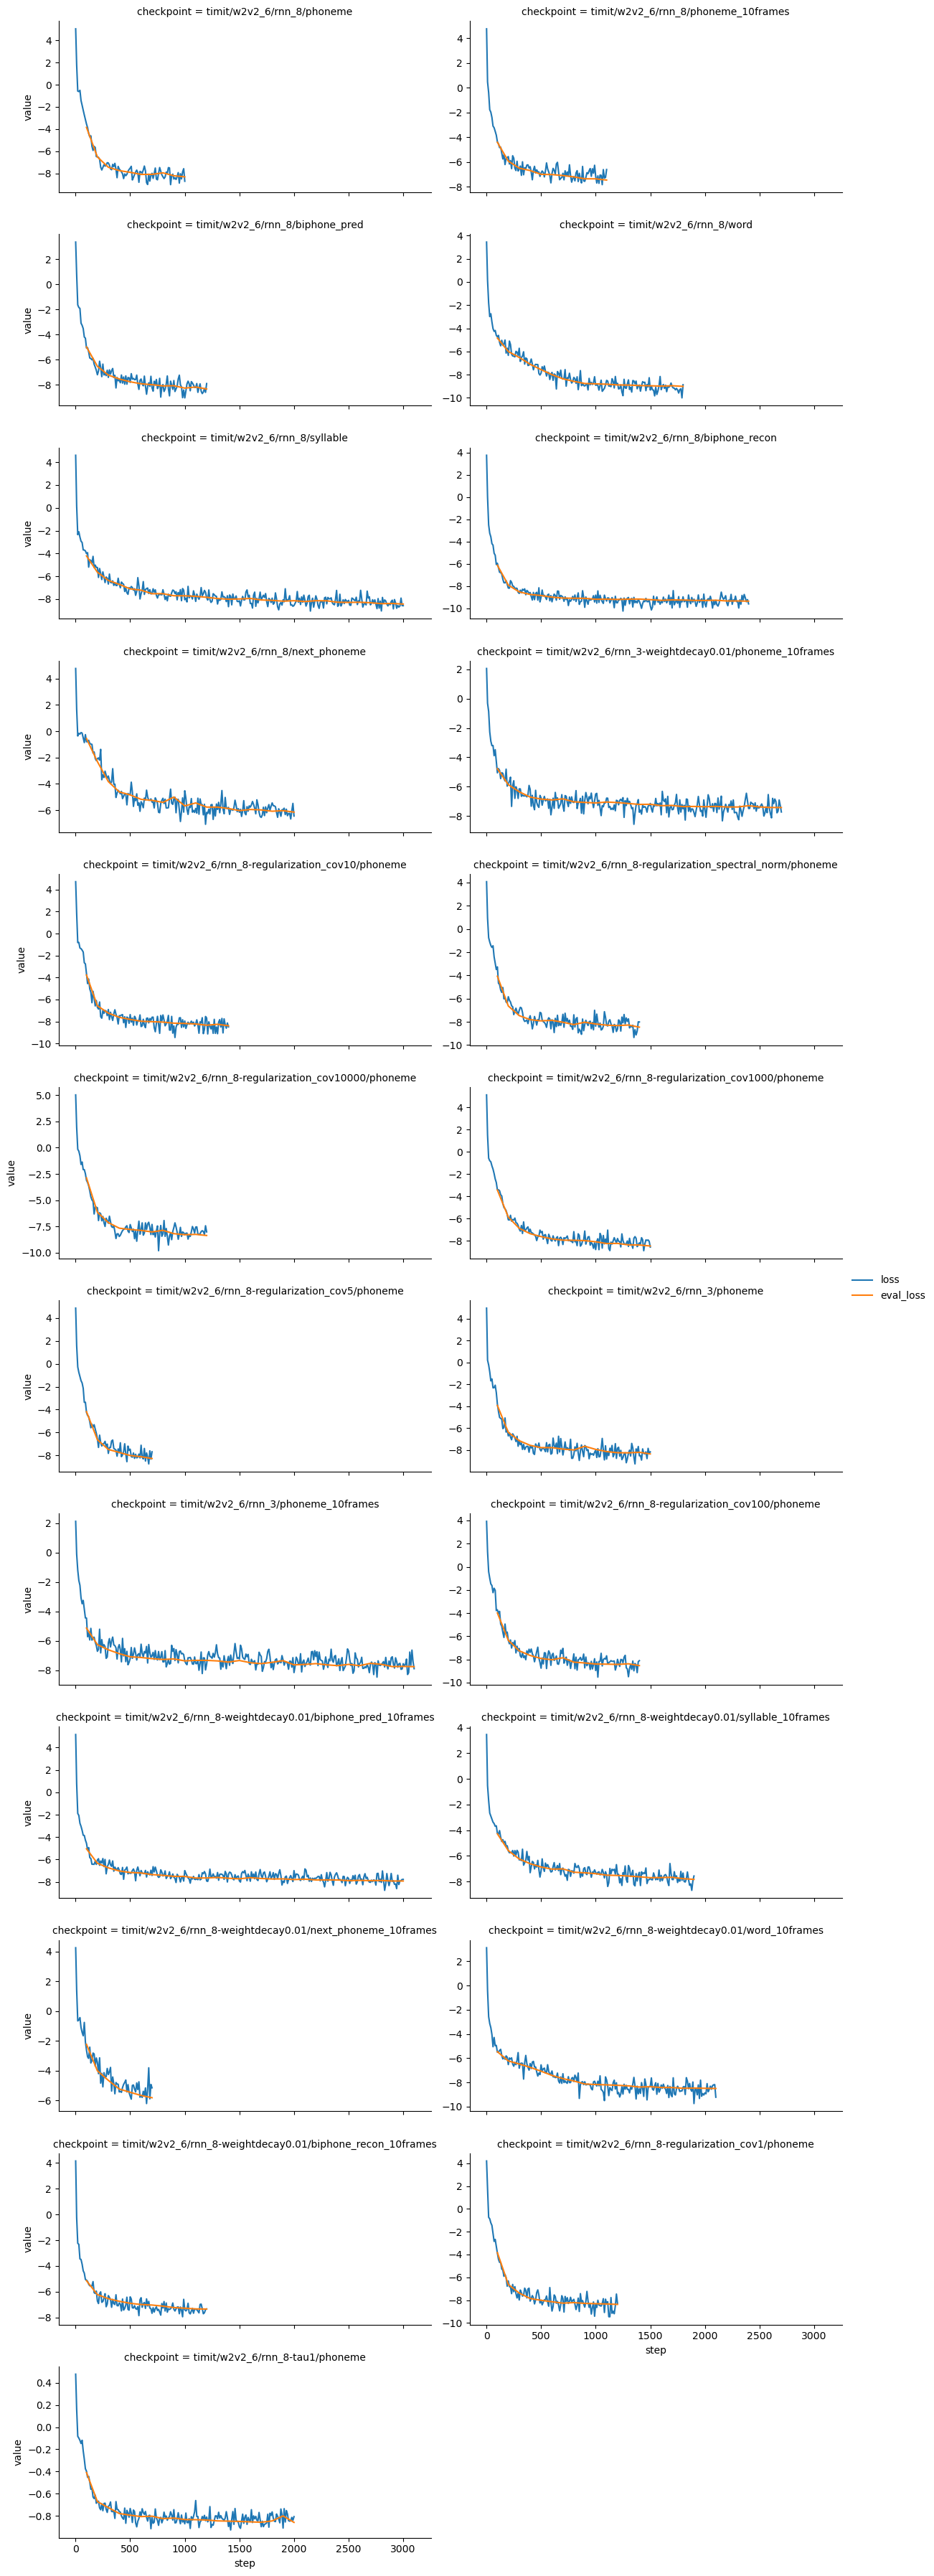

In [8]:
# Plot training and validation loss for all models
g = sns.FacetGrid(log_df_long, col="checkpoint", col_wrap=2, aspect=2, sharey=False)
g.map(sns.lineplot, "step", "value", "variable")
g.add_legend()

## Anisotropy study

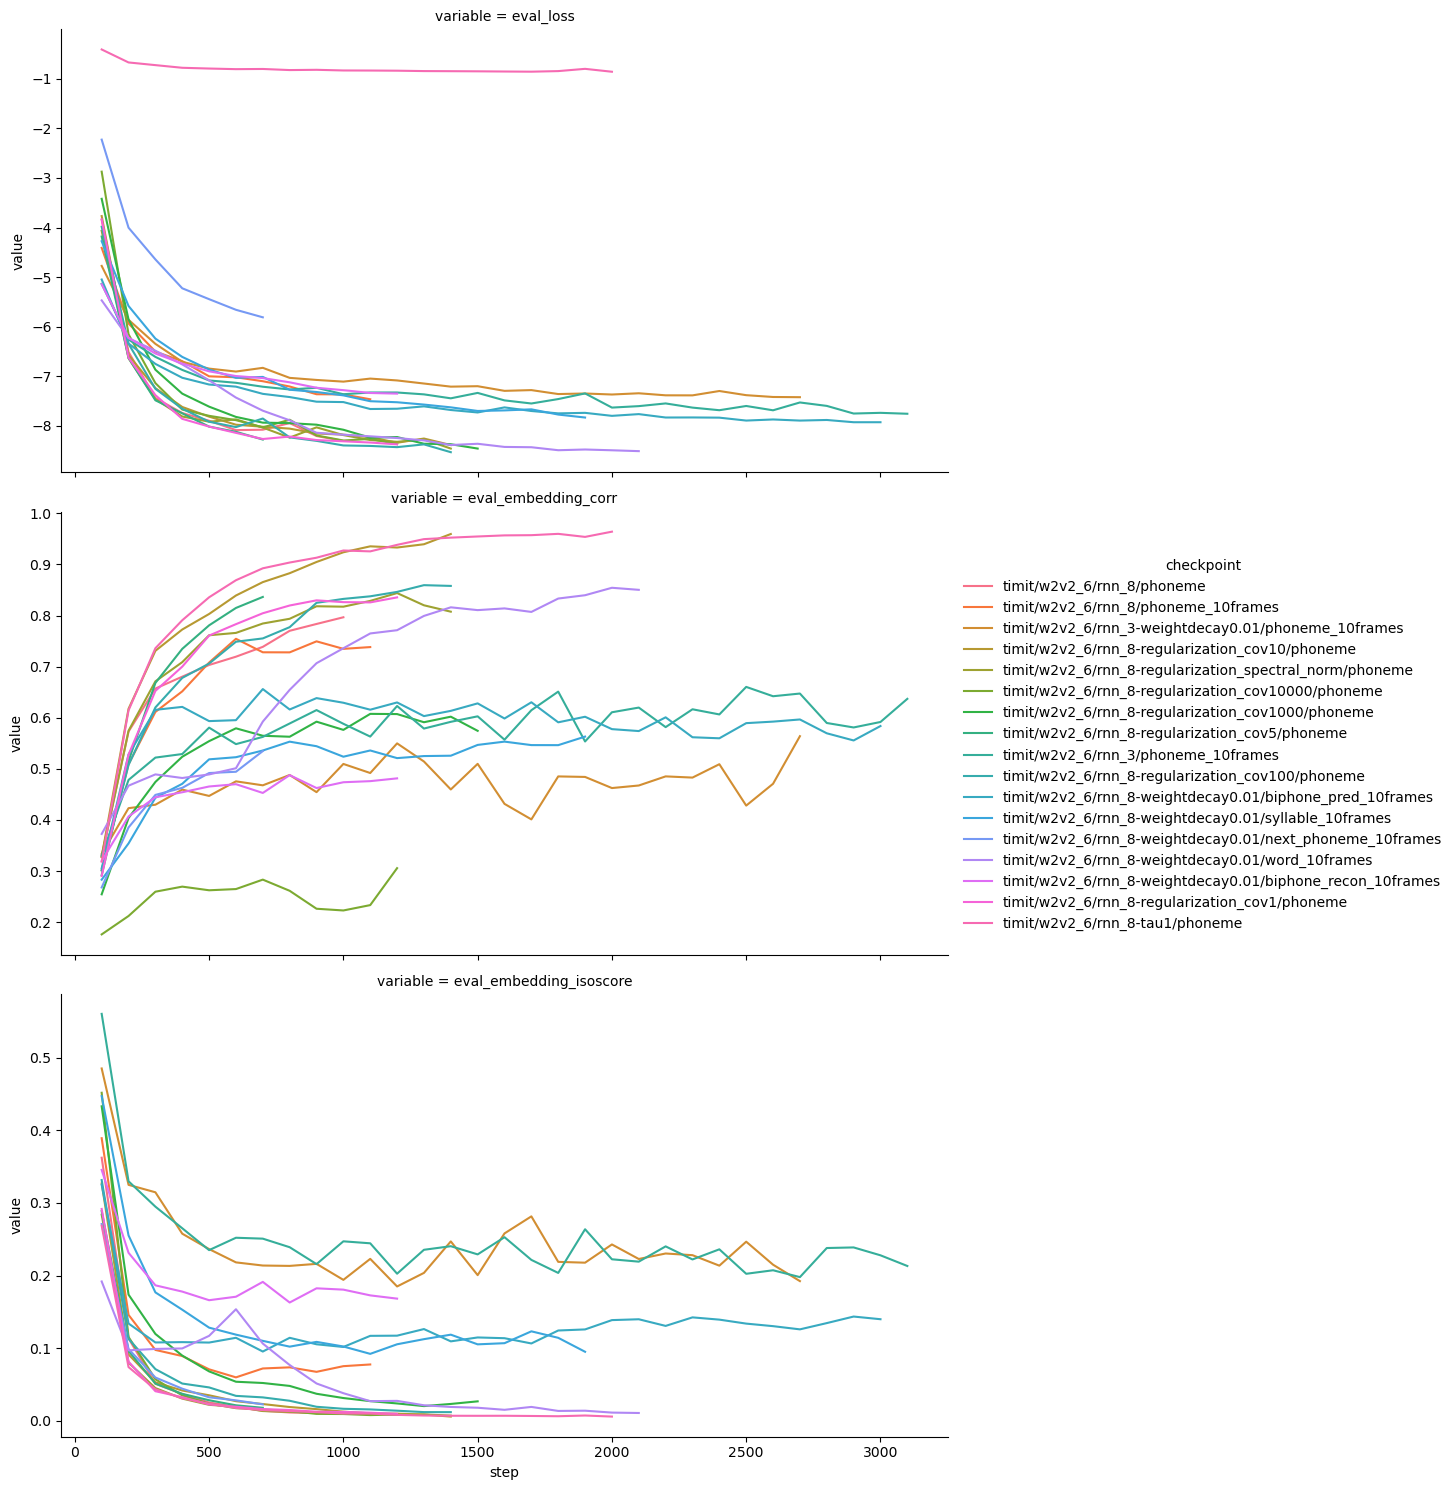

In [9]:
sns.relplot(data=log_df[~log_df.eval_embedding_corr.isna()][["step", "eval_loss", "eval_embedding_corr", "eval_embedding_isoscore"]]
                    .reset_index(level=1, drop=True).reset_index().melt(id_vars=["checkpoint", "step"]),
            x="step", y="value", hue="checkpoint", kind="line", row="variable", aspect=2, facet_kws={"sharey": False})

## Cosine temperature study

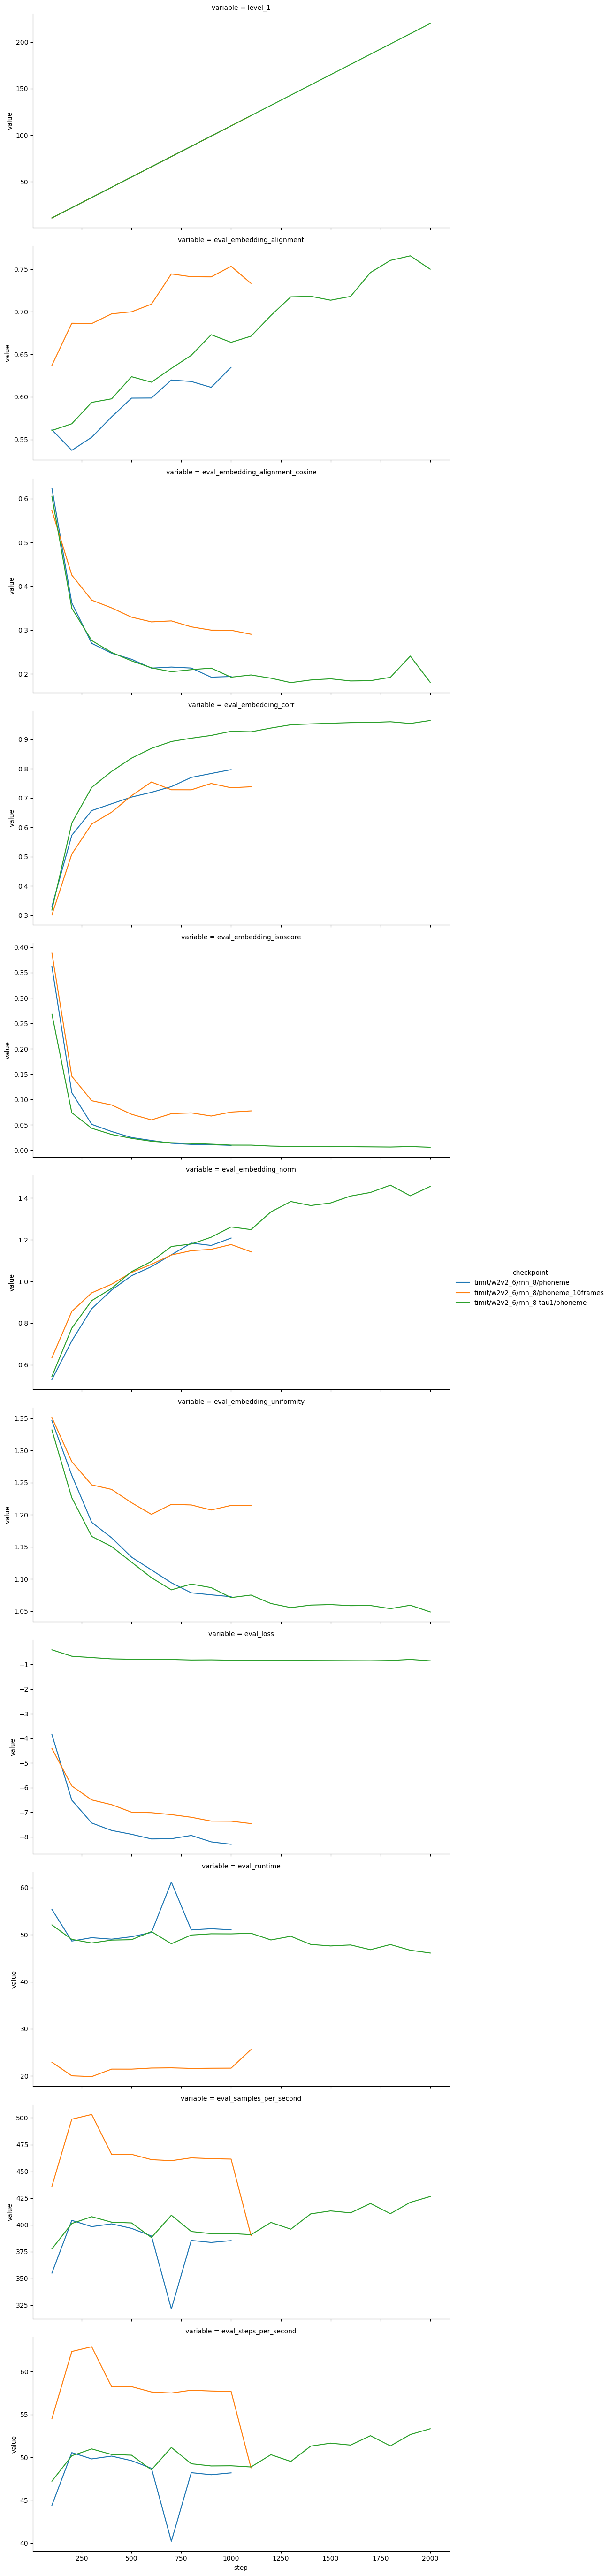

In [10]:
log_df_temperature_study = log_df.loc[log_df.index.get_level_values("checkpoint").str.endswith(("rnn_8/phoneme", "rnn_8-tau1/phoneme", "rnn_8/phoneme_10frames"))]
log_df_temperature_study = log_df_temperature_study[["step"] + [col for col in log_df_temperature_study if col.startswith("eval")]].dropna()
sns.relplot(data=log_df_temperature_study.reset_index().melt(id_vars=["checkpoint", "step"]),
            x="step", y="value", kind="line", row="variable", hue="checkpoint", aspect=2, facet_kws={"sharey": False})